Rendering 3D projected ΛCDM vs CTC...
Saved snap_1.png (frame 0)
Saved snap_1.png (frame 0)
Saved snap_2.png (frame 31)
Saved snap_3.png (frame 58)
Saved snap_4.png (frame 89)
Saved: bullet3d_ctc_vs_lcdm.gif


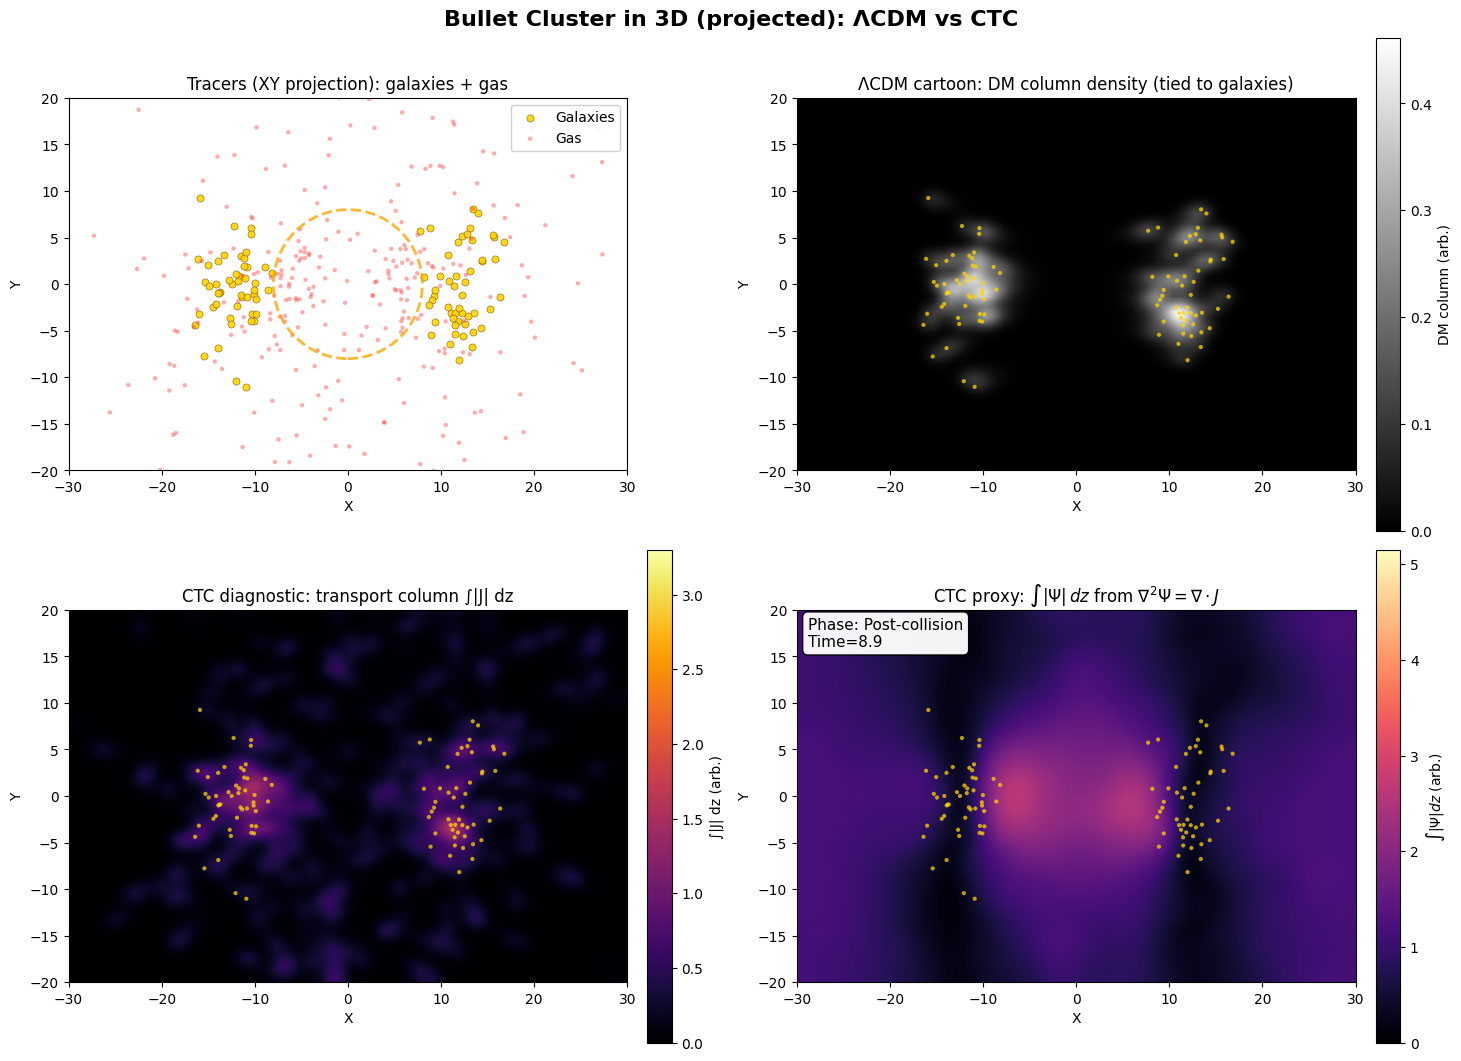

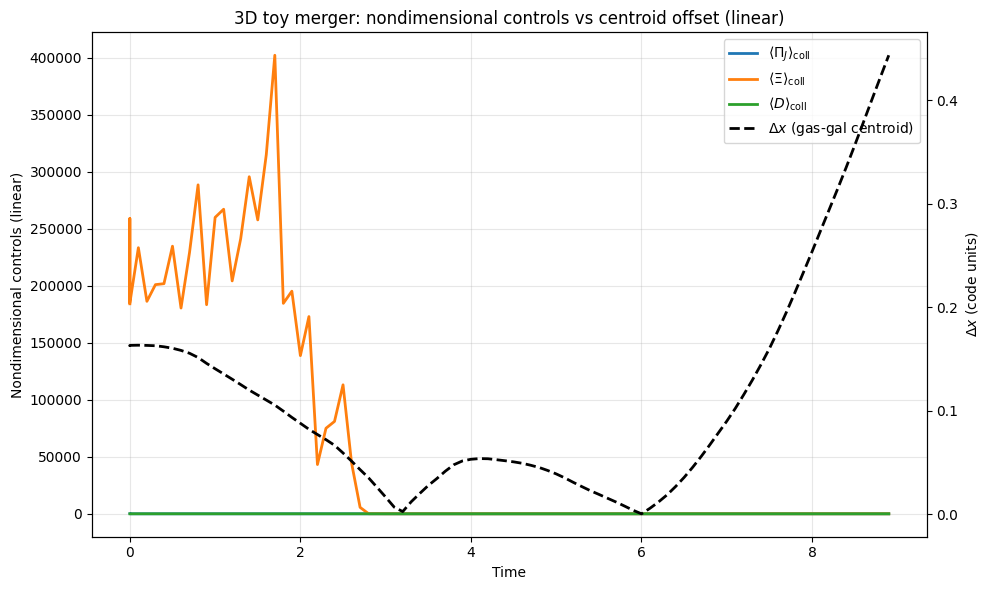

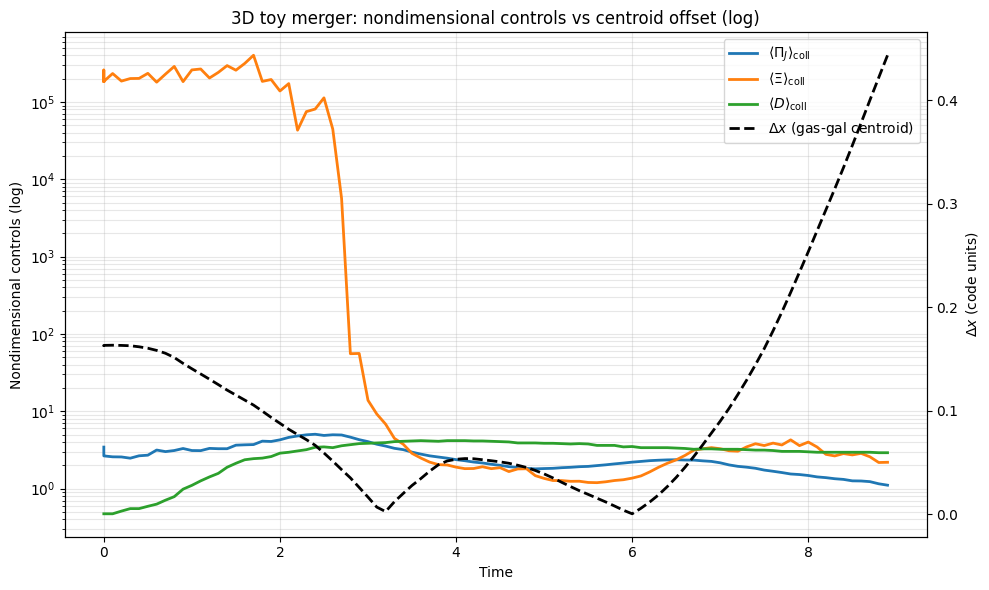

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.ndimage import gaussian_filter
import warnings
from matplotlib.patches import Circle
warnings.filterwarnings("ignore")

# ============================================================
# 3D Bullet Cluster Cartoon (ΛCDM vs CTC) with LOS projection
# + Nondimensional controls extracted from SAME 3D fields:
#   ΠJ = |J|/(ρ c_s)
#   Ξ  = |∇·J| / |∇ρ|
#   D  = λ L / v  with λ inferred from existing drag/slowdown (NO new tuning)
#
# Outputs:
#   - bullet3d_ctc_vs_lcdm.gif
#   - snap_1.png ... snap_4.png
#   - nondim_controls_linear.png
#   - nondim_controls_log.png
# ============================================================

np.random.seed(7)

# ---------------- Settings ----------------
N_FRAMES = 90
DT = 0.10

SAVE_GIF = True
GIF_NAME = "bullet3d_ctc_vs_lcdm.gif"
GIF_FPS = 12
GIF_DPI = 180

SAVE_SNAPSHOTS = True
SNAP_FRAMES = [0, int(0.35*N_FRAMES), int(0.65*N_FRAMES), N_FRAMES-1]

# Domain (3D box)
XLIM = (-30, 30)
YLIM = (-20, 20)
ZLIM = (-20, 20)

# 3D grid (keep moderate for speed)
NX, NY, NZ = 96, 72, 72
xg = np.linspace(*XLIM, NX)
yg = np.linspace(*YLIM, NY)
zg = np.linspace(*ZLIM, NZ)
dx = xg[1]-xg[0]
dy = yg[1]-yg[0]
dz = zg[1]-zg[0]

# Interaction region radius (3D)
COLLISION_R = 8.0

# Particle counts
N_GAL = 100
N_GAS = 300

# Cluster separation and velocities
V0 = 3.0
SIG_GAL = (2.0, 2.0, 2.0)
SIG_GAS = (3.2, 3.2, 3.2)

# Gas dissipation + isotropization
DRAG = 0.985
COLLISION_SLOW = 0.55

# Correlated thermal kicks for gas (OU)
OU_RHO = 0.92
OU_SIGMA = 0.10
eta = None  # will be initialized after gas arrays exist

# Field smoothing (spatial)
SMOOTH_DENS = 1.2
SMOOTH_J = 1.3
SMOOTH_DIV = 1.0
SMOOTH_PSI = 1.3

# Temporal smoothing for fields (reduces flicker)
BETA_FIELD = 0.25  # 0..1, lower = smoother

# Color scaling stability
WARMUP = 10
PCTL = 99.3
FREEZE_CLIM = True

# Nondimensional c_s (effective sound speed; fixed reference scale)
CS = 1.0

# ---------------- Helpers ----------------
def gaussian_particles(mean, sig, n):
    return (np.random.normal(mean[0], sig[0], n),
            np.random.normal(mean[1], sig[1], n),
            np.random.normal(mean[2], sig[2], n))

def deposit_scalar_trilinear(x, y, z, w, grid):
    # deposit weights w into grid (NY,NX,NZ indexing note: stored as [NY,NX,NZ] for imshow)
    for xi, yi, zi, wi in zip(x, y, z, w):
        if (xi < XLIM[0]) or (xi > XLIM[1]) or (yi < YLIM[0]) or (yi > YLIM[1]) or (zi < ZLIM[0]) or (zi > ZLIM[1]):
            continue
        i = np.searchsorted(xg, xi) - 1
        j = np.searchsorted(yg, yi) - 1
        k = np.searchsorted(zg, zi) - 1
        if i < 0 or i >= NX-1 or j < 0 or j >= NY-1 or k < 0 or k >= NZ-1:
            continue
        tx = (xi - xg[i])/(xg[i+1]-xg[i] + 1e-12)
        ty = (yi - yg[j])/(yg[j+1]-yg[j] + 1e-12)
        tz = (zi - zg[k])/(zg[k+1]-zg[k] + 1e-12)

        c000 = (1-tx)*(1-ty)*(1-tz)
        c100 = tx*(1-ty)*(1-tz)
        c010 = (1-tx)*ty*(1-tz)
        c110 = tx*ty*(1-tz)
        c001 = (1-tx)*(1-ty)*tz
        c101 = tx*(1-ty)*tz
        c011 = (1-tx)*ty*tz
        c111 = tx*ty*tz

        grid[j, i, k]     += wi*c000
        grid[j, i+1, k]   += wi*c100
        grid[j+1, i, k]   += wi*c010
        grid[j+1, i+1, k] += wi*c110

        grid[j, i, k+1]     += wi*c001
        grid[j, i+1, k+1]   += wi*c101
        grid[j+1, i, k+1]   += wi*c011
        grid[j+1, i+1, k+1] += wi*c111

def deposit_J_trilinear(x, y, z, vx, vy, vz):
    Jx = np.zeros((NY, NX, NZ), float)
    Jy = np.zeros((NY, NX, NZ), float)
    Jz = np.zeros((NY, NX, NZ), float)
    ones = np.ones_like(x)

    deposit_scalar_trilinear(x, y, z, vx*ones, Jx)
    deposit_scalar_trilinear(x, y, z, vy*ones, Jy)
    deposit_scalar_trilinear(x, y, z, vz*ones, Jz)

    Jx = gaussian_filter(Jx, sigma=SMOOTH_J)
    Jy = gaussian_filter(Jy, sigma=SMOOTH_J)
    Jz = gaussian_filter(Jz, sigma=SMOOTH_J)
    return Jx, Jy, Jz

def divergence_3d(Jx, Jy, Jz):
    dJx_dx = np.gradient(Jx, dx, axis=1)
    dJy_dy = np.gradient(Jy, dy, axis=0)
    dJz_dz = np.gradient(Jz, dz, axis=2)
    divJ = dJx_dx + dJy_dy + dJz_dz
    return gaussian_filter(divJ, sigma=SMOOTH_DIV)

def poisson_fft_3d(source):
    # Solve ∇²Ψ = source in Fourier space (periodic cartoon)
    S = source - np.mean(source)
    Sy, Sx, Sz = S.shape
    kx = np.fft.fftfreq(Sx, d=dx) * 2*np.pi
    ky = np.fft.fftfreq(Sy, d=dy) * 2*np.pi
    kz = np.fft.fftfreq(Sz, d=dz) * 2*np.pi
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="xy")
    K2 = KX**2 + KY**2 + KZ**2
    K2[0,0,0] = 1.0
    Sk = np.fft.fftn(S)
    Psik = -Sk / K2
    Psi = np.real(np.fft.ifftn(Psik))
    return gaussian_filter(Psi, sigma=SMOOTH_PSI)

def proj_los(field3d, axis=2, mode="sum_abs"):
    if mode == "sum_abs":
        return np.sum(np.abs(field3d), axis=axis)
    elif mode == "sum":
        return np.sum(field3d, axis=axis)
    else:
        raise ValueError("mode not recognized")

def robust_vmax(a, p=PCTL):
    return float(max(np.percentile(a[np.isfinite(a)], p), 1e-9))

def phase_label(t):
    if t < 4.0:
        return "Approach"
    elif t < 8.0:
        return "Mid-collision"
    return "Post-collision"

# ---------------- Collision-zone mask ON THE GRID SHAPE (NY,NX,NZ) ----------------
# The array are indexed as [j(y), i(x), k(z)] -> shape (NY,NX,NZ)
X3 = xg[None, :, None]   # (1, NX, 1)
Y3 = yg[:, None, None]   # (NY, 1, 1)
Z3 = zg[None, None, :]   # (1, 1, NZ)
mask_coll_3d = (X3**2 + Y3**2 + Z3**2) <= (COLLISION_R**2)  # (NY,NX,NZ) by broadcasting

# ---------------- Nondimensional extraction helpers ----------------
def grad_rho_mag(rho3):
    # rho3 shape: (NY,NX,NZ) with axes (y,x,z)
    drho_dx = np.gradient(rho3, dx, axis=1)
    drho_dy = np.gradient(rho3, dy, axis=0)
    drho_dz = np.gradient(rho3, dz, axis=2)
    return np.sqrt(drho_dx**2 + drho_dy**2 + drho_dz**2)

def infer_lambda_from_existing_model(gas_x, gas_y, gas_z):
    """
    λ is inferred ONLY from knobs you already have:
      - background drag: DRAG
      - extra slowdown inside collision zone: COLLISION_SLOW
    No new tuning parameters introduced.

    Interpret as an effective decay rate per dt for coherent velocity.
    """
    base_lambda = (1.0 - DRAG) / DT
    extra_lambda = (1.0 - COLLISION_SLOW) / DT

    r = np.sqrt(gas_x**2 + gas_y**2 + gas_z**2)
    in_coll = (r < COLLISION_R)

    # average effective lambda weighted by whether particles are in collision zone
    frac = np.mean(in_coll) if len(in_coll) else 0.0
    lam_eff = base_lambda + frac * extra_lambda
    return lam_eff

# ---------------- Initialize particles (3D) ----------------
# Galaxies
g1x, g1y, g1z = gaussian_particles(mean=(-15, 0, 0), sig=SIG_GAL, n=N_GAL//2)
g2x, g2y, g2z = gaussian_particles(mean=(+15, 0, 0), sig=SIG_GAL, n=N_GAL//2)
gal_x = np.concatenate([g1x, g2x])
gal_y = np.concatenate([g1y, g2y])
gal_z = np.concatenate([g1z, g2z])
gal_vx = np.concatenate([np.full(N_GAL//2, +V0), np.full(N_GAL//2, -V0)])
gal_vy = np.random.normal(0, 0.4, N_GAL)
gal_vz = np.random.normal(0, 0.4, N_GAL)

# Gas
s1x, s1y, s1z = gaussian_particles(mean=(-15, 0, 0), sig=SIG_GAS, n=N_GAS//2)
s2x, s2y, s2z = gaussian_particles(mean=(+15, 0, 0), sig=SIG_GAS, n=N_GAS//2)
gas_x = np.concatenate([s1x, s2x])
gas_y = np.concatenate([s1y, s2y])
gas_z = np.concatenate([s1z, s2z])
gas_vx = np.concatenate([np.full(N_GAS//2, +V0), np.full(N_GAS//2, -V0)])
gas_vy = np.random.normal(0, 0.7, N_GAS)
gas_vz = np.random.normal(0, 0.7, N_GAS)

eta = np.zeros((N_GAS, 3))

# ---------------- Field buffers for temporal smoothing ----------------
DM_prev = None
J_prev = None
Psi_prev = None

# vmax trackers
vmax_dm = None
vmax_J = None
vmax_P = None

# ---------------- Nondimensional time series ----------------
ts = []
PiJ_series = []
Xi_series  = []
D_series   = []
dx_series  = []

# ---------------- Build initial fields ----------------
# ΛCDM DM density tied to galaxies (cartoon)
dm3 = np.zeros((NY, NX, NZ), float)
deposit_scalar_trilinear(gal_x, gal_y, gal_z, np.ones_like(gal_x), dm3)
dm3 = gaussian_filter(dm3, sigma=SMOOTH_DENS)
DM2 = proj_los(dm3, axis=2, mode="sum")  # DM column density

# CTC transport
Jx, Jy, Jz = deposit_J_trilinear(np.concatenate([gal_x, gas_x]),
                                 np.concatenate([gal_y, gas_y]),
                                 np.concatenate([gal_z, gas_z]),
                                 np.concatenate([gal_vx, gas_vx]),
                                 np.concatenate([gal_vy, gas_vy]),
                                 np.concatenate([gal_vz, gas_vz]))
Jmag3 = np.sqrt(Jx**2 + Jy**2 + Jz**2)
J2 = proj_los(Jmag3, axis=2, mode="sum")  # transport column magnitude

divJ3 = divergence_3d(Jx, Jy, Jz)
Psi3 = poisson_fft_3d(divJ3)
P2 = proj_los(Psi3, axis=2, mode="sum_abs")

DM_prev = DM2.copy()
J_prev = J2.copy()
Psi_prev = P2.copy()

vmax_dm = robust_vmax(DM2)
vmax_J  = robust_vmax(J2)
vmax_P  = robust_vmax(P2)

# ---------------- Initial nondimensional values (frame 0) ----------------
rho3 = np.zeros((NY, NX, NZ), float)
deposit_scalar_trilinear(np.concatenate([gal_x, gas_x]),
                         np.concatenate([gal_y, gas_y]),
                         np.concatenate([gal_z, gas_z]),
                         np.ones(N_GAL + N_GAS), rho3)
rho3 = gaussian_filter(rho3, sigma=SMOOTH_DENS)

gradR = grad_rho_mag(rho3)
PiJ = Jmag3 / (rho3*CS + 1e-12)
Xi  = np.abs(divJ3) / (gradR + 1e-12)

PiJ_series.append(float(np.mean(PiJ[mask_coll_3d])))
Xi_series.append(float(np.mean(Xi[mask_coll_3d])))

lam_eff = infer_lambda_from_existing_model(gas_x, gas_y, gas_z)
v_bulk = float(np.mean(np.sqrt(gal_vx**2 + gal_vy**2 + gal_vz**2)))
D_series.append(float(lam_eff * COLLISION_R / (v_bulk + 1e-12)))

dx_series.append(float(abs(np.mean(gas_x) - np.mean(gal_x))))
ts.append(0.0)

# ---------------- Plot setup ----------------
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14.5, 10.5), constrained_layout=True)
fig.suptitle("Bullet Cluster Cartoon in 3D (projected): ΛCDM vs CTC", fontsize=16, fontweight="bold")

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(*XLIM); ax.set_ylim(*YLIM)
    ax.set_aspect("equal")
    ax.set_xlabel("X"); ax.set_ylabel("Y")

# Panel 1: tracers projected to XY
ax1.set_title("Tracers (XY projection): galaxies + gas", fontsize=12)
gal_sc = ax1.scatter(gal_x, gal_y, s=26, c="#FFD400", edgecolors="#8A5A00", linewidth=0.45, alpha=0.90, label="Galaxies")
gas_sc = ax1.scatter(gas_x, gas_y, s=10, c="#FF2D2D", edgecolors="none", alpha=0.40, label="Gas")
ax1.add_patch(Circle((0,0), COLLISION_R, fill=False, color="orange", linestyle="--", linewidth=2.0, alpha=0.8))
ax1.legend(loc="upper right", framealpha=0.9)

# Panel 2: ΛCDM DM column density
ax2.set_title("ΛCDM cartoon: DM column density (tied to galaxies)", fontsize=12)
im_dm = ax2.imshow(DM2, origin="lower",
                   extent=[*XLIM, *YLIM], cmap="gray", vmin=0, vmax=vmax_dm, interpolation="bilinear")
fig.colorbar(im_dm, ax=ax2, fraction=0.046, pad=0.02).set_label("DM column (arb.)", fontsize=10)

# Panel 3: CTC |J| column
ax3.set_title("CTC diagnostic: transport column ∫|J| dz", fontsize=12)
im_J = ax3.imshow(J2, origin="lower",
                  extent=[*XLIM, *YLIM], cmap="inferno", vmin=0, vmax=vmax_J, interpolation="bilinear")
fig.colorbar(im_J, ax=ax3, fraction=0.046, pad=0.02).set_label("∫|J| dz (arb.)", fontsize=10)

# Panel 4: CTC |Psi| column
ax4.set_title(r"CTC proxy: $\int |\Psi|\,dz$ from $\nabla^2\Psi=\nabla\cdot J$", fontsize=12)
im_P = ax4.imshow(P2, origin="lower",
                  extent=[*XLIM, *YLIM], cmap="magma", vmin=0, vmax=vmax_P, interpolation="bilinear")
fig.colorbar(im_P, ax=ax4, fraction=0.046, pad=0.02).set_label(r"$\int|\Psi|dz$ (arb.)", fontsize=10)

# Overlay moving galaxies (NOT frozen)
ov2 = ax2.scatter(gal_x, gal_y, s=9, c="#FFD400", alpha=0.75, edgecolors="none")
ov3 = ax3.scatter(gal_x, gal_y, s=9, c="#FFD400", alpha=0.75, edgecolors="none")
ov4 = ax4.scatter(gal_x, gal_y, s=9, c="#FFD400", alpha=0.75, edgecolors="none")

status = ax4.text(0.02, 0.98, "Phase: Approach\nTime=0.0",
                  transform=ax4.transAxes, va="top", ha="left", fontsize=11,
                  bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.96, edgecolor="black"))

# ---------------- Snapshot saver ----------------
snap_map = {fr:i+1 for i,fr in enumerate(SNAP_FRAMES)}
def save_snap():
    fr = save_snap.frame
    fig.savefig(f"snap_{snap_map[fr]}.png", dpi=220, facecolor="white")
    print(f"Saved snap_{snap_map[fr]}.png (frame {fr})")
save_snap.frame = None

# ---------------- Animation step ----------------
def step(frame):
    global gal_x, gal_y, gal_z, gal_vx, gal_vy, gal_vz
    global gas_x, gas_y, gas_z, gas_vx, gas_vy, gas_vz
    global eta
    global DM_prev, J_prev, Psi_prev
    global vmax_dm, vmax_J, vmax_P

    # --- Update galaxies (ballistic) ---
    gal_x = gal_x + gal_vx*DT
    gal_y = gal_y + gal_vy*DT
    gal_z = gal_z + gal_vz*DT

    # --- Update gas (drag + OU kicks + slowdown in collision region) ---
    gas_x = gas_x + gas_vx*DT
    gas_y = gas_y + gas_vy*DT
    gas_z = gas_z + gas_vz*DT

    gas_vx *= DRAG; gas_vy *= DRAG; gas_vz *= DRAG

    # OU noise
    eta = OU_RHO*eta + np.sqrt(max(1e-12, 1-OU_RHO**2))*np.random.normal(0, 1, eta.shape)
    gas_vx += OU_SIGMA*eta[:,0]
    gas_vy += OU_SIGMA*eta[:,1]
    gas_vz += OU_SIGMA*eta[:,2]

    # Collision region slows directed motion + isotropizes
    r = np.sqrt(gas_x**2 + gas_y**2 + gas_z**2)
    mask = (r < COLLISION_R)
    if np.any(mask):
        gas_vx[mask] *= COLLISION_SLOW
        gas_vy[mask] *= COLLISION_SLOW
        gas_vz[mask] *= COLLISION_SLOW
        gas_vx[mask] += 0.18*eta[mask,0]
        gas_vy[mask] += 0.18*eta[mask,1]
        gas_vz[mask] += 0.18*eta[mask,2]

    # --- Recompute fields (3D) ---
    dm3 = np.zeros((NY, NX, NZ), float)
    deposit_scalar_trilinear(gal_x, gal_y, gal_z, np.ones_like(gal_x), dm3)
    dm3 = gaussian_filter(dm3, sigma=SMOOTH_DENS)
    DM2_new = proj_los(dm3, axis=2, mode="sum")

    Jx, Jy, Jz = deposit_J_trilinear(np.concatenate([gal_x, gas_x]),
                                     np.concatenate([gal_y, gas_y]),
                                     np.concatenate([gal_z, gas_z]),
                                     np.concatenate([gal_vx, gas_vx]),
                                     np.concatenate([gal_vy, gas_vy]),
                                     np.concatenate([gal_vz, gas_vz]))
    Jmag3 = np.sqrt(Jx**2 + Jy**2 + Jz**2)
    J2_new = proj_los(Jmag3, axis=2, mode="sum")

    divJ3 = divergence_3d(Jx, Jy, Jz)
    Psi3 = poisson_fft_3d(divJ3)
    P2_new = proj_los(Psi3, axis=2, mode="sum_abs")

    # Temporal smoothing
    DM2 = (1-BETA_FIELD)*DM_prev + BETA_FIELD*DM2_new
    J2  = (1-BETA_FIELD)*J_prev  + BETA_FIELD*J2_new
    P2  = (1-BETA_FIELD)*Psi_prev + BETA_FIELD*P2_new
    DM_prev, J_prev, Psi_prev = DM2, J2, P2

    # Color scaling (warmup then freeze)
    if (not FREEZE_CLIM) or (frame < WARMUP):
        vmax_dm = 0.8*vmax_dm + 0.2*robust_vmax(DM2)
        vmax_J  = 0.8*vmax_J  + 0.2*robust_vmax(J2)
        vmax_P  = 0.8*vmax_P  + 0.2*robust_vmax(P2)

    # --- Nondimensional extraction (from SAME 3D fields) ---
    # Build total density rho3 from all particles (NO new params)
    rho3 = np.zeros((NY, NX, NZ), float)
    deposit_scalar_trilinear(np.concatenate([gal_x, gas_x]),
                             np.concatenate([gal_y, gas_y]),
                             np.concatenate([gal_z, gas_z]),
                             np.ones(N_GAL + N_GAS), rho3)
    rho3 = gaussian_filter(rho3, sigma=SMOOTH_DENS)

    gradR = grad_rho_mag(rho3)
    PiJ = Jmag3 / (rho3*CS + 1e-12)
    Xi  = np.abs(divJ3) / (gradR + 1e-12)

    PiJ_series.append(float(np.mean(PiJ[mask_coll_3d])))
    Xi_series.append(float(np.mean(Xi[mask_coll_3d])))

    lam_eff = infer_lambda_from_existing_model(gas_x, gas_y, gas_z)
    v_bulk = float(np.mean(np.sqrt(gal_vx**2 + gal_vy**2 + gal_vz**2)))
    D_series.append(float(lam_eff * COLLISION_R / (v_bulk + 1e-12)))

    dx_series.append(float(abs(np.mean(gas_x) - np.mean(gal_x))))
    ts.append(frame*DT)

    # --- Update visuals ---
    gal_sc.set_offsets(np.c_[gal_x, gal_y])
    gas_sc.set_offsets(np.c_[gas_x, gas_y])

    im_dm.set_data(DM2); im_dm.set_clim(0, vmax_dm)
    im_J.set_data(J2);   im_J.set_clim(0, vmax_J)
    im_P.set_data(P2);   im_P.set_clim(0, vmax_P)

    ov2.set_offsets(np.c_[gal_x, gal_y])
    ov3.set_offsets(np.c_[gal_x, gal_y])
    ov4.set_offsets(np.c_[gal_x, gal_y])

    t = frame*DT
    status.set_text(f"Phase: {phase_label(t)}\nTime={t:.1f}")

    if SAVE_SNAPSHOTS and frame in snap_map:
        save_snap.frame = frame
        save_snap()

    return (gal_sc, gas_sc, im_dm, im_J, im_P, ov2, ov3, ov4, status)

# ---------------- Render ----------------
print("Rendering 3D projected ΛCDM vs CTC...")
anim = FuncAnimation(fig, step, frames=N_FRAMES, interval=100, blit=False)

if SAVE_GIF:
    anim.save(GIF_NAME, writer=PillowWriter(fps=GIF_FPS), dpi=GIF_DPI,
              savefig_kwargs={"facecolor":"white"})
    print(f"Saved: {GIF_NAME}")

plt.show()

# ============================================================
# POST-RUN: nondimensional plots (linear + log)
# ============================================================
ts = np.array(ts)
PiJ_series = np.array(PiJ_series)
Xi_series  = np.array(Xi_series)
D_series   = np.array(D_series)
dx_series  = np.array(dx_series)

# --- linear ---
figL, ax = plt.subplots(figsize=(10,6))
ax.plot(ts, PiJ_series, lw=2, label=r'$\langle \Pi_J\rangle_{\rm coll}$')
ax.plot(ts, Xi_series,  lw=2, label=r'$\langle \Xi\rangle_{\rm coll}$')
ax.plot(ts, D_series,   lw=2, label=r'$\langle D\rangle_{\rm coll}$')
ax.set_xlabel("Time")
ax.set_ylabel("Nondimensional controls (linear)")
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(ts, dx_series, 'k--', lw=2, label=r'$\Delta x$ (gas-gal centroid)')
ax2.set_ylabel(r'$\Delta x$ (code units)')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="upper right")

ax.set_title("3D toy merger: nondimensional controls vs centroid offset (linear)")
plt.tight_layout()
plt.savefig("nondim_controls_linear.png", dpi=300)
plt.show()

# --- log (protect zeros) ---
eps = 1e-30
figG, ax = plt.subplots(figsize=(10,6))
ax.plot(ts, np.maximum(PiJ_series, eps), lw=2, label=r'$\langle \Pi_J\rangle_{\rm coll}$')
ax.plot(ts, np.maximum(Xi_series,  eps), lw=2, label=r'$\langle \Xi\rangle_{\rm coll}$')
ax.plot(ts, np.maximum(D_series,   eps), lw=2, label=r'$\langle D\rangle_{\rm coll}$')
ax.set_yscale("log")
ax.set_xlabel("Time")
ax.set_ylabel("Nondimensional controls (log)")
ax.grid(True, which="both", alpha=0.3)

ax2 = ax.twinx()
ax2.plot(ts, dx_series, 'k--', lw=2, label=r'$\Delta x$ (gas-gal centroid)')
ax2.set_ylabel(r'$\Delta x$ (code units)')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="upper right")

ax.set_title("3D toy merger: nondimensional controls vs centroid offset (log)")
plt.tight_layout()
plt.savefig("nondim_controls_log.png", dpi=300)
plt.show()
